# LGMVIP Data Science Internship October 2022 

# Task 2 : Stock Market Prediction And Forecasting Using Stacked LSTM

# Import Libraries 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

#  Import dataset 

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
data.shape

(2035, 8)

In [5]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


# Exploratory Data Analysis

In [6]:
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [7]:
df= data.reset_index()['Open']
print(df)

0       234.05
1       234.55
2       240.00
3       233.30
4       233.55
         ...  
2030    117.60
2031    120.10
2032    121.80
2033    120.30
2034    122.10
Name: Open, Length: 2035, dtype: float64


Text(0.5, 1.0, 'Open')

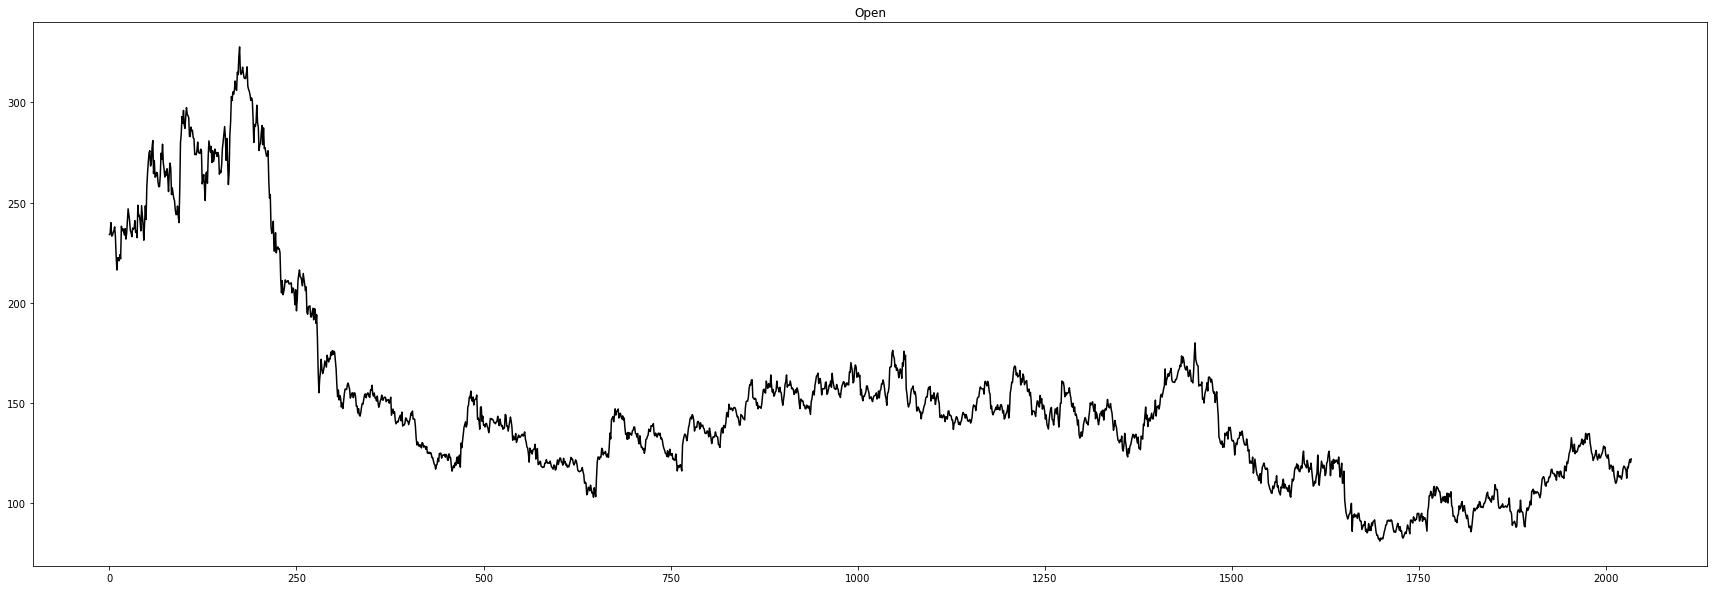

In [8]:
plt.subplots(figsize = (30,10))
plt.plot(df , color ="black")
plt.title("Open")

In [9]:
scaler = MinMaxScaler(feature_range = (0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
df.shape

(2035, 1)

In [10]:
print(df)

[[0.6202352 ]
 [0.62226277]
 [0.64436334]
 ...
 [0.16504461]
 [0.15896188]
 [0.16626115]]


# Sampling The Data 

In [11]:
training_size = int( len(df) * 0.75)
testing_size  = len(df) - training_size
train_data , test_data = df[0 : training_size, :], df[training_size : len(df), :1]
training_size , testing_size

(1526, 509)

In [12]:
train_data , test_data

(array([[0.6202352 ],
        [0.62226277],
        [0.64436334],
        ...,
        [0.18491484],
        [0.15774534],
        [0.16180049]]),
 array([[0.15774534],
        [0.15774534],
        [0.16991079],
        [0.13746959],
        [0.14963504],
        [0.16605839],
        [0.15369019],
        [0.14152474],
        [0.13341444],
        [0.13260341],
        [0.12368208],
        [0.12246553],
        [0.13625304],
        [0.11719384],
        [0.13746959],
        [0.15004055],
        [0.15308191],
        [0.15794809],
        [0.15186537],
        [0.14557989],
        [0.14497161],
        [0.14801298],
        [0.14476886],
        [0.11719384],
        [0.11151663],
        [0.10563666],
        [0.10218978],
        [0.09712084],
        [0.09691809],
        [0.11131387],
        [0.10644769],
        [0.11111111],
        [0.1202352 ],
        [0.11922141],
        [0.13219789],
        [0.10969181],
        [0.11232766],
        [0.10097324],
        [0.097120

In [13]:
#convert array of values into dataset
def create_dataset(dataset, time_step=1):
    train_X, train_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        train_X.append(a)
        train_Y.append(dataset[i + time_step, 0])
    return np.array(train_X), np.array(train_Y)

In [14]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [15]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [17]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

# Fit The LSTM Model 

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)


Epoch 1/100
23/23 [==============================] - 9s 191ms/step - loss: 0.0217 - val_loss: 0.0081
Epoch 2/100
23/23 [==============================] - 3s 134ms/step - loss: 0.0033 - val_loss: 7.7313e-04
Epoch 3/100
23/23 [==============================] - 3s 130ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/100
23/23 [==============================] - 3s 141ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
23/23 [==============================] - 3s 135ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/100
23/23 [==============================] - 3s 137ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
23/23 [==============================] - 3s 133ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/100
23/23 [==============================] - 3s 132ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100
23/23 [==============================] - 3s 153ms/step - loss: 0.0010 - va

In [21]:
#Lets predict and check performance metrics

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

13/13 [==============================] - 0s 28ms/step


In [22]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

print('RMSE performance matrics : ',math.sqrt(mean_squared_error(y_train, train_predict)) )

RMSE performance matrics :  164.035318611077


In [23]:
print("Test data RMSE : ",math.sqrt(mean_squared_error(y_test , test_predict)) )

Test data RMSE :  106.35279445452191


In [24]:
#Shift train prediction for plotting

look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting

testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df) - 1, :] = test_predict

In [25]:
#Plot baseline

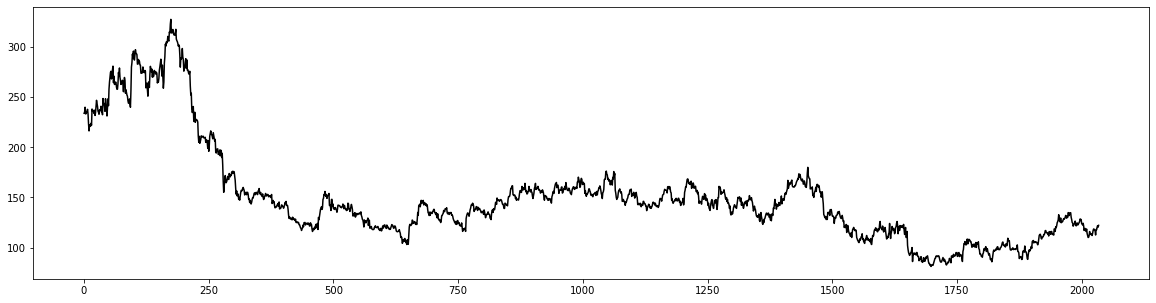

In [26]:
plt.subplots(figsize=(20,5))
plt.plot(scaler.inverse_transform(df), color= 'black')
plt.show()

In [27]:
#Training Prediction and Testing Prediction

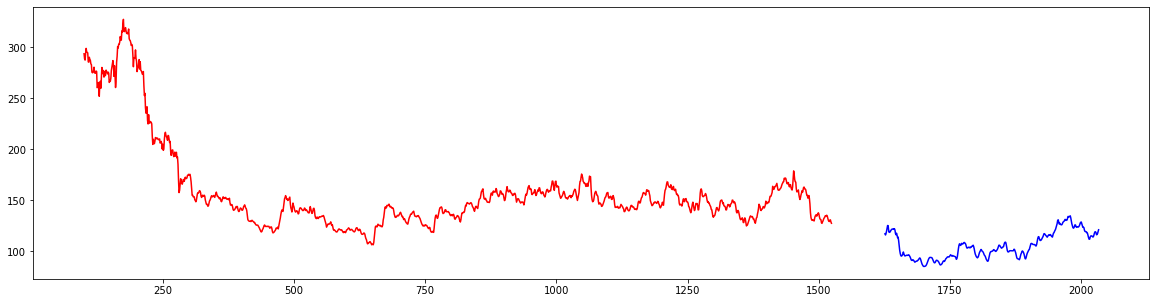

In [28]:
plt.subplots(figsize=(20,5))
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='blue')
plt.show()

In [29]:
#Baseline and train, test prediction

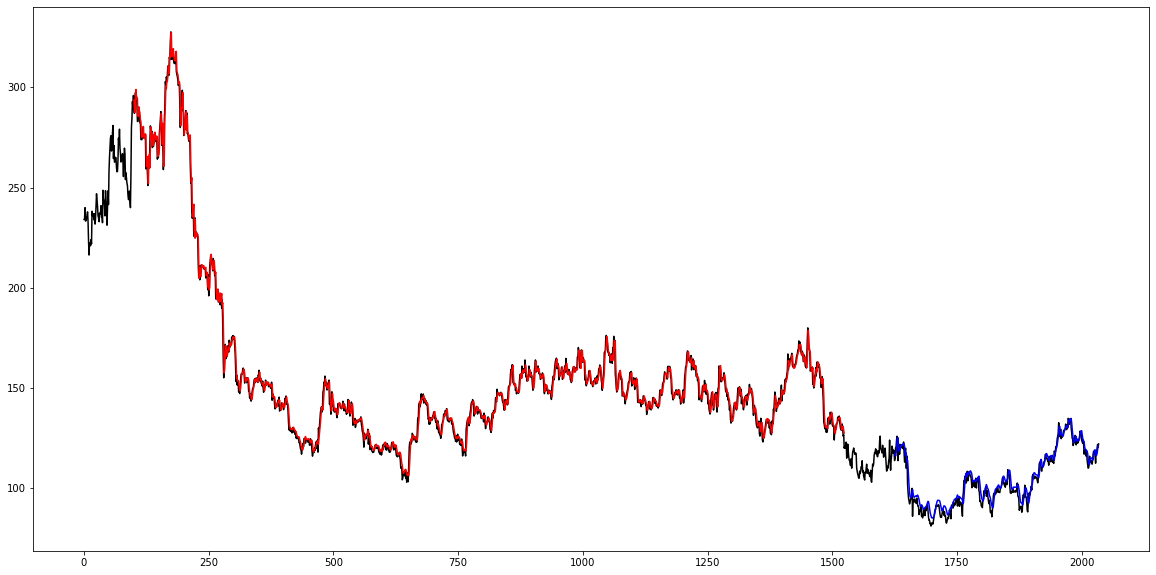

In [30]:
plt.subplots(figsize=(20,10))
plt.plot(scaler.inverse_transform(df), color= 'black')
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='blue')
plt.show()

In [31]:
print("Length of test data : ", len(test_data))

Length of test data :  509


In [32]:
test_data.shape

(509, 1)

In [33]:
#now taking previous 100 days data from test data prediction of future data 

In [34]:
x_ip = test_data[409:].reshape(1,-1)
x_ip.shape

(1, 100)

In [35]:
temp_ip = list(x_ip)
temp_ip = temp_ip[0].tolist()

In [36]:
lst_output=[]
n_steps=100

future_Days= 15

i=0

while(i<future_Days):
    
    if(len(temp_ip)>100):
        x_ip = np.array(temp_ip[1:])
        print("Day {} input {}".format(i,x_ip))
        
        x_ip = x_ip.reshape(1,-1)
        x_ip = x_ip.reshape((1, n_steps, 1))
        yhat = model.predict(x_ip, verbose=0)
        print("Day {} output {}\n".format(i,yhat))
        
        temp_ip.extend(yhat[0].tolist())
        temp_ip = temp_ip[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_ip = x_ip.reshape((1, n_steps,1))
        yhat = model.predict(x_ip, verbose=0)
        print(yhat[0])
        temp_ip.extend(yhat[0].tolist())
        print(len(temp_ip))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.16737176]
101
Day 1 input [0.13746959 0.13990268 0.13017032 0.14152474 0.14111922 0.13138686
 0.12915653 0.13098135 0.1269262  0.15166261 0.15004055 0.14193025
 0.16017843 0.15693431 0.16504461 0.1770073  0.18146796 0.18815896
 0.20924574 0.19424169 0.18106245 0.18207624 0.1960665  0.17680454
 0.18207624 0.18004866 0.18207624 0.18876723 0.19383617 0.19099757
 0.19505272 0.19809408 0.20640714 0.19748581 0.19525547 0.20437956
 0.19870235 0.21796431 0.21553122 0.20600162 0.21654501 0.21654501
 0.2175588  0.19870235 0.19018654 0.17802109 0.175588   0.16301703
 0.16707218 0.17112733 0.17639903 0.18349554 0.1717356  0.16423358
 0.16991079 0.17619627 0.16788321 0.16909976 0.17396594 0.17741281
 0.18268451 0.19221411 0.18896999 0.19018654 0.17396594 0.17092457
 0.16788321 0.17477697 0.16443633 0.14557989 0.15287916 0.15369019
 0.15044607 0.14152474 0.15145985 0.13341444 0.12530414 0.11719384
 0.11780211 0.12489862 0.14132198 0.13098135 0.12935929 0.13240065
 0.12895377 0.12530414 0.13381995

In [37]:
day_new = np.arange(1,101)
day_pred = np.arange(101,116)

In [38]:
fd = df.tolist()
fd.extend(lst_output)

In [39]:
len(df)

2035

In [40]:
2035-100

1935

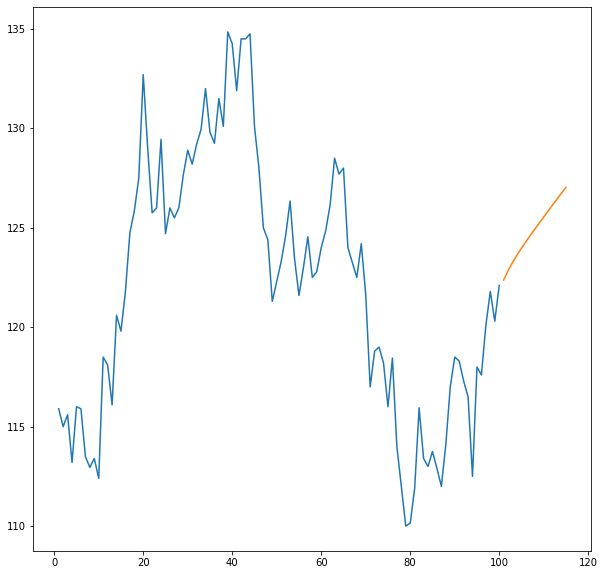

In [41]:
plt.subplots(figsize = (10,10))
plt.plot(day_new, scaler.inverse_transform(df[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))